#Técnicas desbalanceo datos

##Importación de paquetes y carga de datos 

In [185]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, average_precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import KFold, cross_val_score

Carga de datos

In [186]:
data=pd.read_csv('df_nietos2.csv')
data.head()

,Unnamed: 0,ID,CNAE,CNAE_DESCRIPCION,IMPORT_EXPORT,ULT_ACTOMERCANTIL,TAM_EMPRESA,Estado,ACC_EXTRAN,ACC_EMPRESA,...,A-17-DIF_CAMBIO_34_diff,A-17-DIF_CAMBIO_23_diff,A-17-DIF_CAMBIO_12_diff,A-20-IMPUESTOS_34_diff,A-20-IMPUESTOS_23_diff,A-20-IMPUESTOS_12_diff,Subvencion,ALTO_CRECIMIENTO_CALCU,GACELA_CALCU,MODELO_CALCU
0,0,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,...,NaN,NaN,NaN,0.222222,inf,NaN,1,0,0,1
1,1,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,...,NaN,NaN,NaN,0.222222,inf,NaN,1,0,0,1
2,2,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,...,NaN,NaN,NaN,0.222222,inf,NaN,1,0,0,1
3,3,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.084848,0.666667,1,0,0,0
4,4,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.084848,0.666667,1,0,0,0


In [187]:
data.drop(columns=['Unnamed: 0'], inplace=True, axis=1)

##Preparación de datos para el entrenamiento

###Variables categóricas

In [188]:
data.describe(include='object').T

,count,unique,top,freq
CNAE_DESCRIPCION,2661,174,Actividades de programación informática,341
IMPORT_EXPORT,2661,4,Nada,2334
ULT_ACTOMERCANTIL,2661,680,2022-05-20 02:00:00,61
TAM_EMPRESA,2661,5,Microempresa,2251
Estado,2661,2,Viva,2660
INFO_ADMIN,2661,1,SI,2661
ACT_MEDIOS,1230,3,Activa en Redes,706
ESTRUCTURA,33,2,Cabecera Grupo Consolidado,19
MUJERES_CONSEJO,2661,2,NO,2267
InicioActividad,2661,571,2016-12-22 01:00:00,60


Primero cambiamos las fechas de Inicio Actividad y Último Acto mercantil para quedarnos solo con el año

In [189]:
data['InicioActividad'] = pd.to_datetime(data['InicioActividad'])
data['ULT_ACTOMERCANTIL'] = pd.to_datetime(data['ULT_ACTOMERCANTIL'])

<Axes: xlabel='Inicio Actividad', ylabel='Count'>

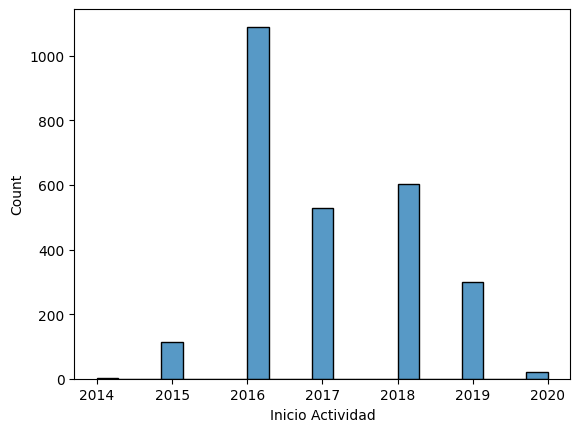

In [190]:
data['Inicio Actividad'] = data['InicioActividad'].dt.year
data.drop(columns=['InicioActividad'], inplace=True, axis=1)
sns.histplot(x = "Inicio Actividad", data = data)

<Axes: xlabel='ULT_ACTOMERCANTIL_Y', ylabel='Count'>

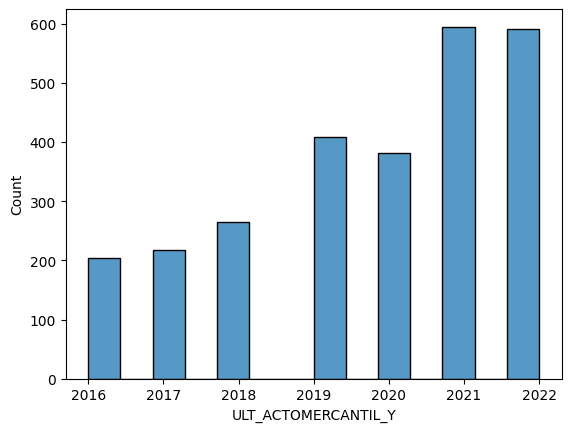

In [191]:
data['ULT_ACTOMERCANTIL_Y'] = data['ULT_ACTOMERCANTIL'].dt.year
data.drop(columns=['ULT_ACTOMERCANTIL'], inplace=True, axis=1)
sns.histplot(x = "ULT_ACTOMERCANTIL_Y", data = data)

Por otro lado, la Descripción CNAE no la necesitamos ya que tenemos el código. La Organización que aporta la subvención y la descripción de la misma también lo podemos eliminar. 

In [192]:
data.drop(columns=['CNAE_DESCRIPCION', 'DESCRIPCIÓN', 'ORGANISMO'], axis=1, inplace=True)

El resto de los datos categóricos los vamos a mantener. Posteriormente los pasaremos a numéricos para el entrenamiento del modelo. 

###Tratamiento de datos faltantes

<Axes: >

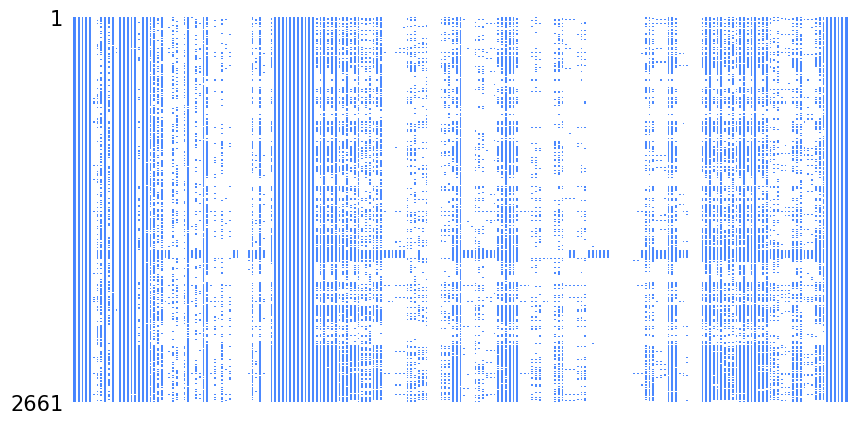

In [193]:
missingno.matrix(data,sparkline=False, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0))

In [194]:
# Calculamos el porcentaje de missing values para cada atributo
percent_missing = data.isnull().sum() *100 / len(data)
# Creamos un DataFrame con los porcentajes y el nombre de cada atributo
missing_values_df = pd.DataFrame({'percent_missing': percent_missing})
# Atributos con algun missing value
missing_values_df[missing_values_df['percent_missing'] > 40]

,percent_missing
ACC_EXTRAN,95.415257
ACC_EMPRESA,71.063510
NUMACCIONISTAS,44.832770
ACT_MEDIOS,53.776776
ESTRUCTURA,98.759865
...,...
A-15-GAS_FIN_12_diff,48.966554
A-17-DIF_CAMBIO_34_diff,90.755355
A-17-DIF_CAMBIO_23_diff,88.575723
A-17-DIF_CAMBIO_12_diff,89.815859


Todas las columnas anteriores tiene más de la mitad de los datos faltante, por lo que se procede a eliminarlas ya que la incertidumbre es muy alta

In [195]:
missing_values_df_40= missing_values_df[missing_values_df['percent_missing'] > 40]
df_missing = missing_values_df_40.T

data2= data.drop(columns=list(df_missing.columns), axis=1)

<Axes: >

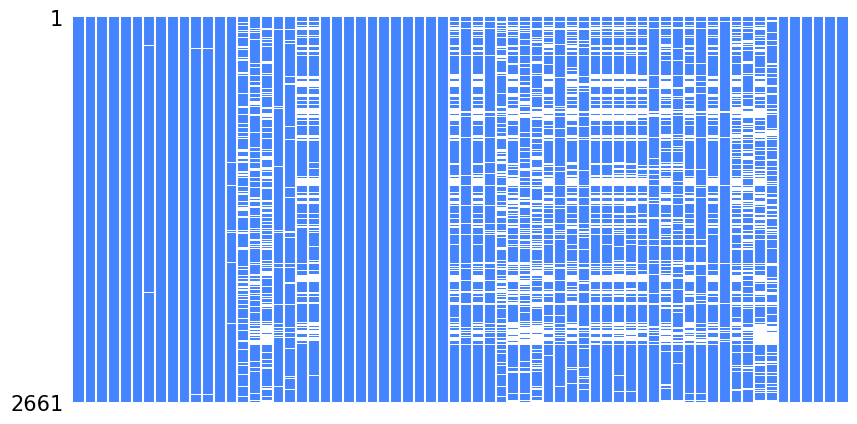

In [196]:
missingno.matrix(data2,sparkline=False, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0))

In [197]:
# Calculamos el porcentaje de missing values para cada atributo
percent_missing = data2.isnull().sum() * 100 / len(data)
# Creamos un DataFrame con los porcentajes y el nombre de cada atributo
missing_values_df = pd.DataFrame({'percent_missing': percent_missing})
# Atributos con algun missing value
missing_values_df[missing_values_df['percent_missing'] > 0]

,percent_missing
CARGOS_ADMIN,0.150319
AÑO CONCESION,0.450958
IMPORTE NOMINAL,0.413378
LIQ_1,1.841413
END_1,22.209696
EMP_1,23.412251
A-II-INM_MAT_1,30.402104
B-III-DEU_COM_1,5.110861
B-VII-EFECTIVO_1,6.614055
A-PN-1_FP_1,23.299511


Para los datos de activo-pasivo-cr rellenamos los datos faltantes con 0

In [198]:
df_missing = missing_values_df.T
columnas=list(df_missing.columns)
for col in columnas:
  if '_1' in col or '_2' in col:
    data2[col] = data[col].fillna(0)

El año de concesión y el importe nominal se refieren a la subvención. Si el dato es nulo será que no hay, por lo que lo rellenamos con 0. 
Por último, los cargos administrativos son el número registrado de administradores. Entendemos que mínimo debe haber un administrador, por lo que asignaremos este número.

In [199]:
data2['CARGOS_ADMIN']=data2['CARGOS_ADMIN'].fillna(1)
data2['AÑO CONCESION']=data2['AÑO CONCESION'].fillna(0)
data2['IMPORTE NOMINAL']=data2['IMPORTE NOMINAL'].fillna(0)

<Axes: >

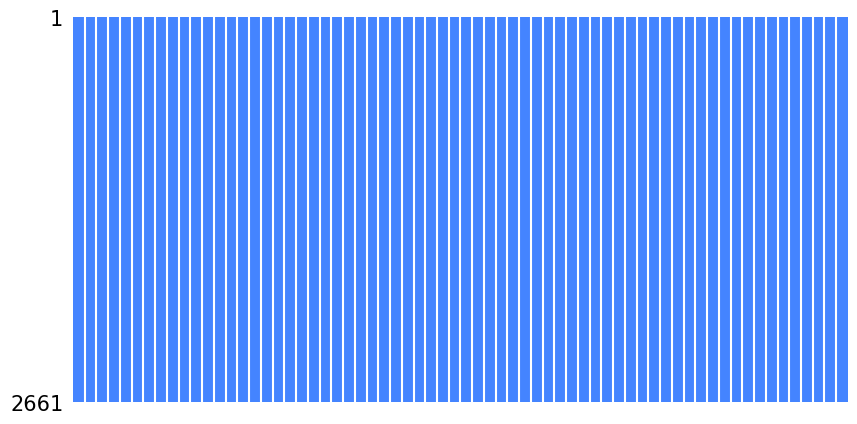

In [200]:
missingno.matrix(data2,sparkline=False, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0))

Como se puede observar ya no hay datos faltantes. 

Por último, antes de preparar los datos, vamos a eliminar la columna de 'ID' de la empresa y los balances 3 y 4, ya que para la predicción, las nuevas empresas no tendrán estos balances

In [201]:
data2.drop(columns=['ID'], axis=1, inplace=True)

Vemos el número de columnas del dataset

In [202]:
print('Número de columnas: ', len(list(data2.columns)))

Número de columnas:  65


In [203]:
data2.to_csv('data2.csv')

###Preparación de los datos para el entrenamiento de los modelos

Primero vamos a filtrar los datos para quedarnos solo con ls registros del modelo (más de 3 balances) y eliminamos las columnas de ventas, gacela calculado, modelo calculado.

In [204]:
modelo=data2[data2['MODELO_CALCU']==1]

In [205]:
modelo.drop(columns=['GACELA_CALCU', 'MODELO_CALCU', 'A-1-VENTAS_1', 'A-1-VENTAS_12_diff', 'A-1-VENTAS_23_diff'], axis=1, inplace=True)

<ipython-input-205-3defef370779>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelo.drop(columns=['GACELA_CALCU', 'MODELO_CALCU', 'A-1-VENTAS_1', 'A-1-VENTAS_12_diff', 'A-1-VENTAS_23_diff'], axis=1, inplace=True)


A continuación convertimos las variables target en variables categoricas

In [206]:
modelo2=pd.get_dummies(modelo)

Separamos la variable target (ALTO_CRECIMIENTO_CALCULADO) y dividimos los datos en entrenammiento y test



In [207]:
cols = list(modelo2.columns)
cols.remove("ALTO_CRECIMIENTO_CALCU") 
X = modelo2[cols].values
# Variable a predecir: 
Y = modelo['ALTO_CRECIMIENTO_CALCU']

Vemos si hay valores infinitos y los reemplazamos para evitar errores

In [208]:
# Check for infinite values
print(np.isfinite(X).all())

False


In [209]:
X = np.nan_to_num(X, nan=0, posinf=1e9, neginf=-1e9)

In [210]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

##GENERAL

In [211]:
# Division of dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)

Vamos a utilizar el árbol de clasificación para todas las técnicas, ya que así es más fácil su comparativa.

In [212]:
#Creamos lista para guardar todos los accuracy y las matrices de confusión y así poder compararlas
acc_test=[]
recall_test=[]
conf_mat_test=[]

#para validación
acc_val=[]
recall_val=[]
conf_mat_val=[]

##TÉCNICA 1. Ajuste de parámetros del modelo



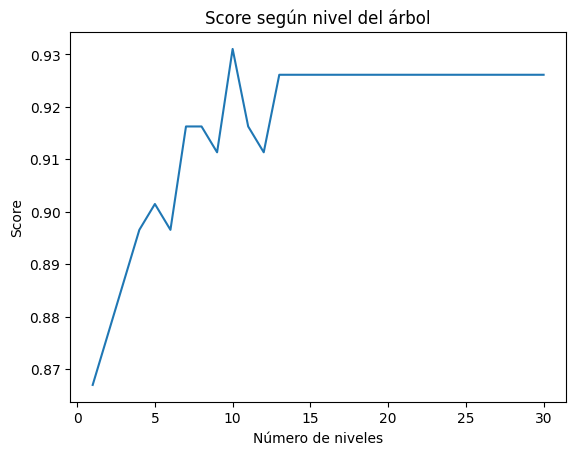

In [213]:
class_tree = tree.DecisionTreeClassifier(random_state=42)
scores = []
num_variables = len(X)
n_niveles = range(1, num_variables + 1)


for n in n_niveles:
    class_tree.set_params(max_depth = n)
    class_tree.fit(X_train, y_train)
    scores.append(class_tree.score(X_test, Y_test))
    
plt.title("Score según nivel del árbol")
plt.xlabel("Número de niveles")
plt.ylabel("Score")
plt.plot(n_niveles[0:30], scores[0:30])
plt.show()

In [214]:
print('Con {} niveles se obtuvo el mayor score'.format(np.argmax(scores)))

Con 9 niveles se obtuvo el mayor score


Primero analizamos la profundidad óptima para el árbol de clasificación

In [215]:
penalizacion=len(modelo2[modelo2['ALTO_CRECIMIENTO_CALCU']==0])/len(modelo2[modelo2['ALTO_CRECIMIENTO_CALCU']==1])
print(penalizacion)

4.8441558441558445


In [216]:
# Entrenamiento
class1 = tree.DecisionTreeClassifier(random_state=42,max_depth = 9,class_weight={1:penalizacion} )
class1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={1: 4.8441558441558445}, max_depth=9,
                       random_state=42)

In [217]:
# Realizamos la predicción
Y_pred1 = class1.predict(X_test)
y_val_pred1 = class1.predict(X_val)

 Test Accuracy: 0.9261083743842364
 Test Recall: 0.8518518518518519
Matriz de confusión de Test:


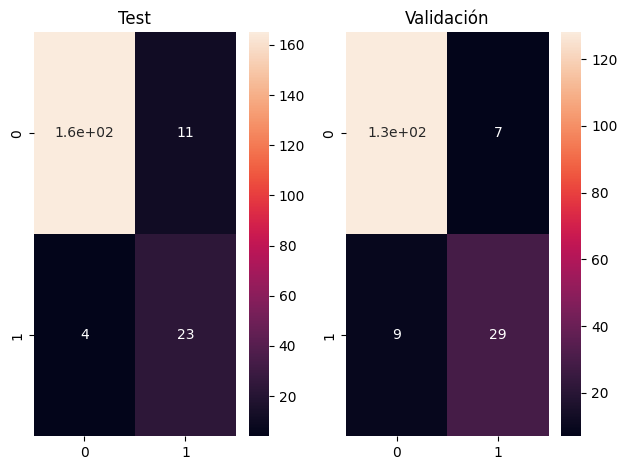

In [218]:
# Evaluamos la prediccion utilizando las metricas
acc1=accuracy_score(Y_test, Y_pred1)
recall1=recall_score(Y_test, Y_pred1)
conf_mat1=confusion_matrix(Y_test,Y_pred1)

val_acc1 = accuracy_score(y_val, y_val_pred1)
val_recall1=recall_score(y_val, y_val_pred1)
val_conf_mat1=confusion_matrix(y_val,y_val_pred1)

acc_test.append(acc1)
conf_mat_test.append(conf_mat1)
recall_test.append(recall1)

acc_val.append(val_acc1)
conf_mat_val.append(val_conf_mat1)
recall_val.append(val_recall1)

print(" Test Accuracy: {}".format(acc1))
print(" Test Recall: {}".format(recall1))
print("Matriz de confusión de Test:")

fig, axs = plt.subplots(1, 2)

sns.heatmap(conf_mat1, annot=True, ax=axs[0])
axs[0].set_title('Test')

sns.heatmap(val_conf_mat1, annot=True, ax=axs[1])
axs[1].set_title('Validación')

plt.tight_layout()
plt.show()

##TÉCNICA 2. MODIFICACIÓN DEL DATASET

###Eliminando muestras de la clase mayoritaria (*subsampling*)

In [219]:
from sklearn.utils import resample

# Se separan los datos en clases mayoritarias y minoritarias
X_minority = X[Y == 1]
X_majority = X[Y == 0]


In [220]:
print(len(X_minority))
print(len(X_majority))

231
1119


In [221]:
# Submuestreo aleatorio de la clase mayoritaria
X_majority_downsampled = resample(X_majority,
                                  replace=False, # Muestreo sin reemplazo
                                  n_samples=len(X_minority), # Igual que la clase minoritaria
                                  random_state=42) # Fijar semilla para reproducibilidad


In [222]:
print(len(X_minority), X_minority.ndim)
print(len(X_majority_downsampled), X_majority.ndim)

231 2
231 2


In [223]:
# Combinar los datos submuestreados con la clase minoritaria
X_balanced = np.concatenate((X_majority_downsampled, X_minority), axis=0)
y_balanced = np.concatenate(([0]*len(X_majority_downsampled), [1]*len(X_minority)))

In [224]:
# Division of dataset
X_train_s, X_test_s, Y_train_s, Y_test_s = train_test_split(X_balanced, y_balanced, test_size = 0.15, random_state = 42)
X_train_s, X_val_s, Y_train_s, Y_val_s = train_test_split(X_train_s, Y_train_s, test_size = 0.15, random_state = 42)

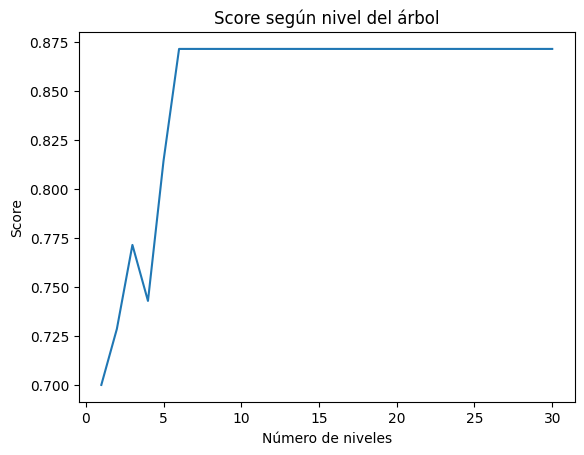

In [225]:
#vemos profundidad del árbol
class_tree = tree.DecisionTreeClassifier(random_state=42)
scores = []
num_variables = len(X_balanced)
n_niveles = range(1, num_variables + 1)


for n in n_niveles:
    class_tree.set_params(max_depth = n)
    class_tree.fit(X_train_s, Y_train_s)
    scores.append(class_tree.score(X_test_s, Y_test_s))
    
plt.title("Score según nivel del árbol")
plt.xlabel("Número de niveles")
plt.ylabel("Score")
plt.plot(n_niveles[0:30], scores[0:30])
plt.show()

In [226]:
print('Con {} niveles se obtuvo el mayor score'.format(np.argmax(scores)))

Con 5 niveles se obtuvo el mayor score


In [227]:
# Entrenamiento
class2 = tree.DecisionTreeClassifier(random_state=42,max_depth = 5)
class2.fit(X_train_s, Y_train_s)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [228]:
# Realizamos la predicción
Y_pred2 = class2.predict(X_test_s)
y_val_pred2=class2.predict(X_val_s)

Accuracy: 0.8142857142857143
Recall: 0.9032258064516129
Matriz de confusión:


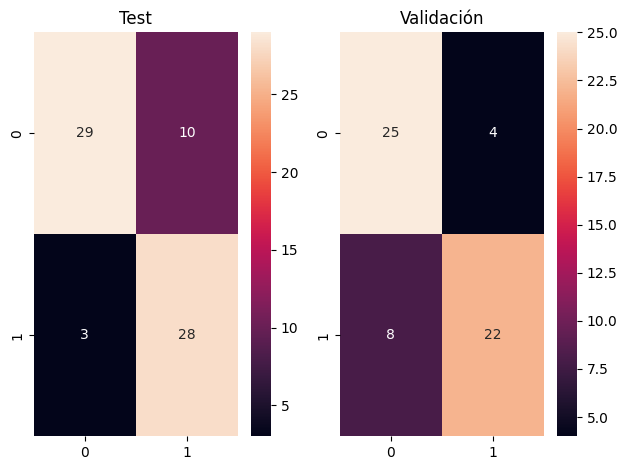

In [229]:
# Evaluamos la prediccion utilizando las metricas
acc2=accuracy_score(Y_test_s, Y_pred2)
recall2=recall_score(Y_test_s, Y_pred2)
conf_mat2=confusion_matrix(Y_test_s,Y_pred2)

val_acc2 = accuracy_score(Y_val_s, y_val_pred2)
val_recall2=recall_score(Y_val_s, y_val_pred2)
val_conf_mat2=confusion_matrix(Y_val_s,y_val_pred2)

acc_test.append(acc2)
recall_test.append(recall2)
conf_mat_test.append(conf_mat2)

acc_val.append(val_acc2)
conf_mat_val.append(val_conf_mat2)
recall_val.append(val_recall2)

print("Accuracy: {}".format(acc2))
print("Recall: {}".format(recall2))
print("Matriz de confusión:")

fig, axs = plt.subplots(1, 2)

sns.heatmap(conf_mat2, annot=True, ax=axs[0])
axs[0].set_title('Test')

sns.heatmap(val_conf_mat2, annot=True, ax=axs[1])
axs[1].set_title('Validación')

plt.tight_layout()
plt.show()

El submuestreo aleatorio puede perder información valiosa en los datos eliminando algunos ejemplos de la clase mayoritaria. Otras técnicas de muestreo, como el submuestreo estratificado o el sobremuestreo de la clase minoritaria, pueden ser más adecuadas dependiendo del conjunto de datos y del modelo que se utilice.

###Duplicando muestras de la clase minoritaria (*oversampling*)

In [230]:
# Separar las muestras de la clase mayoritaria y la clase minoritaria
X_minority = X[Y == 1]
X_majority = X[Y == 0]

# Duplicar las muestras de la clase minoritaria
X_minority_oversampled = resample(X_minority, n_samples=X_majority.shape[0], replace=True)

# Unir las muestras de la clase mayoritaria con las muestras de la clase minoritaria duplicadas
X_balanced = np.vstack((X_majority, X_minority_oversampled))
y_balanced = np.hstack((np.ones(X_majority.shape[0]), np.zeros(X_majority.shape[0])))


In [231]:
print(len(X_balanced), X_balanced.ndim)
print(len(y_balanced), y_balanced.ndim)

2238 2
2238 1


In [232]:
# Division of dataset
X_train_d, X_test_d, Y_train_d, Y_test_d = train_test_split(X_balanced, y_balanced, test_size = 0.15, random_state = 42)
X_train_d, X_val_d, Y_train_d, Y_val_d = train_test_split(X_train_d, Y_train_d, test_size = 0.15, random_state = 42)

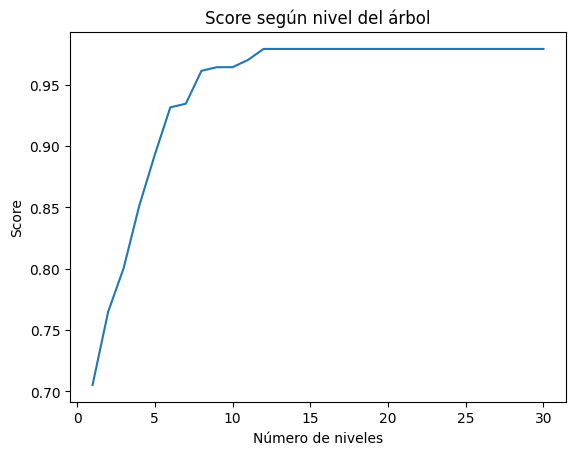

In [233]:
#vemos profundidad del árbol
class_tree = tree.DecisionTreeClassifier(random_state=42)
scores = []
num_variables = len(X_balanced)
n_niveles = range(1, num_variables + 1)


for n in n_niveles:
    class_tree.set_params(max_depth = n)
    class_tree.fit(X_train_d, Y_train_d)
    scores.append(class_tree.score(X_test_d, Y_test_d))
    
plt.title("Score según nivel del árbol")
plt.xlabel("Número de niveles")
plt.ylabel("Score")
plt.plot(n_niveles[0:30], scores[0:30])
plt.show()

In [234]:
print('Con {} niveles se obtuvo el mayor score'.format(np.argmax(scores)))

Con 11 niveles se obtuvo el mayor score


In [235]:
# Entrenamiento
class3 = tree.DecisionTreeClassifier(random_state=42,max_depth = 11)
class3.fit(X_train_d, Y_train_d)

DecisionTreeClassifier(max_depth=11, random_state=42)

In [236]:
# Realizamos la predicción
Y_pred3 = class3.predict(X_test_d)
y_val_pred3=class3.predict(X_val_d)

Accuracy: 0.9702380952380952
Recall: 0.9444444444444444
Matriz de confusión:


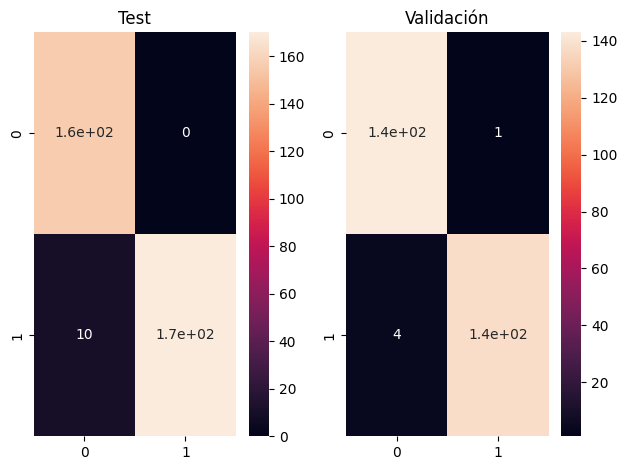

In [237]:
# Evaluamos la prediccion utilizando las metricas
acc3=accuracy_score(Y_test_d, Y_pred3)
recall3=recall_score(Y_test_d, Y_pred3)
conf_mat3=confusion_matrix(Y_test_d,Y_pred3)

val_acc3 = accuracy_score(Y_val_d, y_val_pred3)
val_recall3=recall_score(Y_val_d, y_val_pred3)
val_conf_mat3=confusion_matrix(Y_val_d,y_val_pred3)

acc_test.append(acc3)
recall_test.append(recall3)
conf_mat_test.append(conf_mat3)

acc_val.append(val_acc3)
conf_mat_val.append(val_conf_mat3)
recall_val.append(val_recall3)

print("Accuracy: {}".format(acc3))
print("Recall: {}".format(recall3))
print("Matriz de confusión:")

fig, axs = plt.subplots(1, 2)

sns.heatmap(conf_mat3, annot=True, ax=axs[0])
axs[0].set_title('Test')

sns.heatmap(val_conf_mat3, annot=True, ax=axs[1])
axs[1].set_title('Validación')

plt.tight_layout()
plt.show()

##TÉCNICA 3. MUESTRAS ARTIFICIALES

Generar oversampling creando muestras artificiales.

Para hacer oversampling de la clase minoritaria generando muestras sintéticas, se puede utilizar alguna técnica de aumento de datos como **SMOTE** (Synthetic Minority Over-sampling Technique). SMOTE es una técnica de oversampling que consiste en sintetizar nuevas instancias para la clase minoritaria basándose en la interpolación lineal de las muestras existentes. En otras palabras, SMOTE genera nuevas instancias tomando muestras aleatorias de la clase minoritaria y creando "vecinos sintéticos" a partir de ellas.

In [238]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X, Y)

In [239]:
# Division of dataset
X_train_o, X_test_o, Y_train_o, Y_test_o = train_test_split(X_resampled, y_resampled, test_size = 0.15, random_state = 42)
X_train_o, X_val_o, Y_train_o, Y_val_o = train_test_split(X_train_o, Y_train_o, test_size = 0.15, random_state = 42)

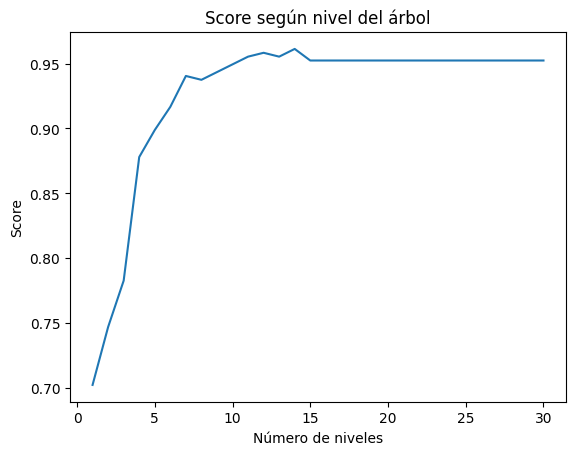

In [240]:
#vemos profundidad del árbol
class_tree = tree.DecisionTreeClassifier(random_state=42)
scores = []
num_variables = len(X_resampled)
n_niveles = range(1, num_variables + 1)


for n in n_niveles:
    class_tree.set_params(max_depth = n)
    class_tree.fit(X_train_o, Y_train_o)
    scores.append(class_tree.score(X_test_o, Y_test_o))
    
plt.title("Score según nivel del árbol")
plt.xlabel("Número de niveles")
plt.ylabel("Score")
plt.plot(n_niveles[0:30], scores[0:30])
plt.show()

In [241]:
print('Con {} niveles se obtuvo el mayor score'.format(np.argmax(scores)))

Con 13 niveles se obtuvo el mayor score


In [242]:
# Entrenamiento
class4 = tree.DecisionTreeClassifier(random_state=42,max_depth = 11)
class4.fit(X_train_o, Y_train_o)

# Realizamos la predicción
Y_pred4 = class4.predict(X_test_o)
y_val_pred4=class4.predict(X_val_o)

Accuracy: 0.9553571428571429
Recall: 0.9691358024691358
Matriz de confusión:


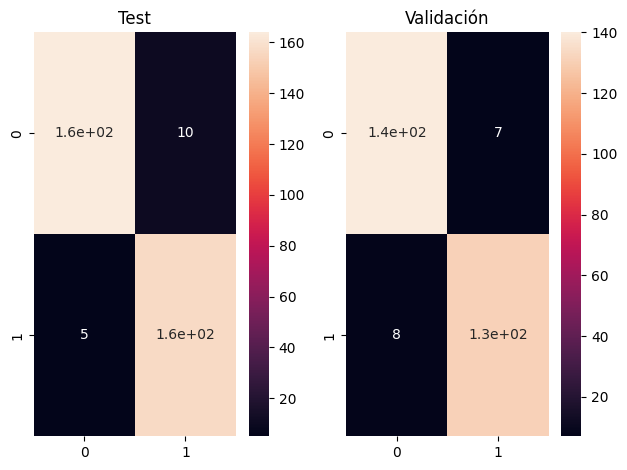

In [243]:
# Evaluamos la prediccion utilizando las metricas
acc4=accuracy_score(Y_test_o, Y_pred4)
recall4=recall_score(Y_test_o, Y_pred4)
conf_mat4=confusion_matrix(Y_test_o,Y_pred4)

val_acc4 = accuracy_score(Y_val_o, y_val_pred4)
val_recall4=recall_score(Y_val_o, y_val_pred4)
val_conf_mat4=confusion_matrix(Y_val_o,y_val_pred4)

acc_test.append(acc4)
recall_test.append(recall4)
conf_mat_test.append(conf_mat4)

acc_val.append(val_acc4)
conf_mat_val.append(val_conf_mat4)
recall_val.append(val_recall4)


print("Accuracy: {}".format(acc4))
print("Recall: {}".format(recall4))
print("Matriz de confusión:")

fig, axs = plt.subplots(1, 2)

sns.heatmap(conf_mat4, annot=True, ax=axs[0])
axs[0].set_title('Test')

sns.heatmap(val_conf_mat4, annot=True, ax=axs[1])
axs[1].set_title('Validación')

plt.tight_layout()
plt.show()

##TÉCNICA 4. COMBINACIÓN DE OVERSAMPLING Y SUBSAMPLIG

Una técnica de desbalanceo que combina subsampling y oversampling se llama **SMOTEENN** (Synthetic Minority Over-sampling Technique Edited Nearest Neighbors). Esta técnica primero aplica SMOTE para generar nuevas muestras sintéticas para la clase minoritaria, y luego realiza undersampling de la clase mayoritaria utilizando la técnica Edited Nearest Neighbors (ENN) para eliminar las muestras redundantes y ruidosas.

In [244]:
from imblearn.combine import SMOTEENN

# Crear objeto SMOTEENN
smote_enn = SMOTEENN(random_state=0)

# Aplicar SMOTEENN a los datos de entrenamiento
X_resampled, y_resampled = smote_enn.fit_resample(X, Y)

In [245]:
# Division of dataset
X_train_sm, X_test_sm, Y_train_sm, Y_test_sm = train_test_split(X_resampled, y_resampled, test_size = 0.15, random_state = 42)
X_train_sm, X_val_sm, Y_train_sm, Y_val_sm = train_test_split(X_train_sm, Y_train_sm, test_size = 0.15, random_state = 42)

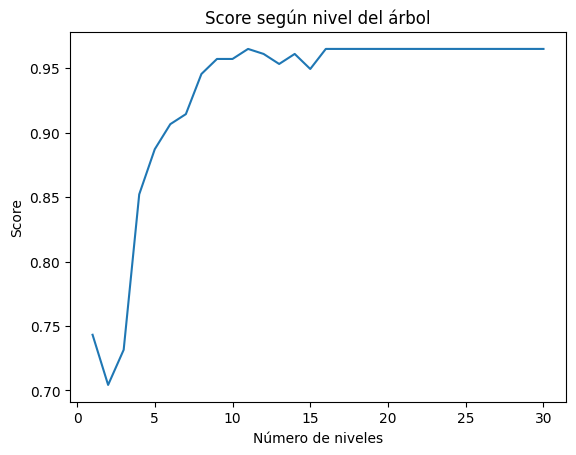

In [246]:
#vemos profundidad del árbol
class_tree = tree.DecisionTreeClassifier(random_state=42)
scores = []
num_variables = len(X_resampled)
n_niveles = range(1, num_variables + 1)


for n in n_niveles:
    class_tree.set_params(max_depth = n)
    class_tree.fit(X_train_sm, Y_train_sm)
    scores.append(class_tree.score(X_test_sm, Y_test_sm))
    
plt.title("Score según nivel del árbol")
plt.xlabel("Número de niveles")
plt.ylabel("Score")
plt.plot(n_niveles[0:30], scores[0:30])
plt.show()

In [247]:
print('Con {} niveles se obtuvo el mayor score'.format(np.argmax(scores)))

Con 10 niveles se obtuvo el mayor score


In [248]:
# Entrenamiento
class5 = tree.DecisionTreeClassifier(random_state=42,max_depth = 10)
class5.fit(X_train_sm, Y_train_sm)

# Realizamos la predicción
Y_pred5 = class5.predict(X_test_sm)
y_val_pred5=class5.predict(X_val_sm)

Accuracy: 0.9571984435797666
Recall: 0.967479674796748
Matriz de confusión:


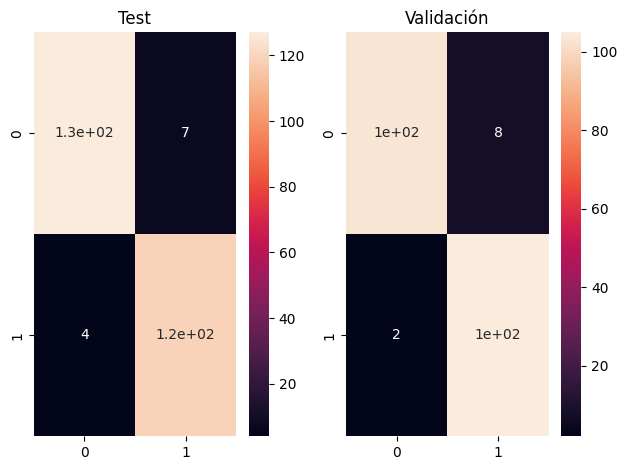

In [249]:
# Evaluamos la prediccion utilizando las metricas
acc5=accuracy_score(Y_test_sm, Y_pred5)
recall5=recall_score(Y_test_sm, Y_pred5)
conf_mat5=confusion_matrix(Y_test_sm,Y_pred5)

val_acc5 = accuracy_score(Y_val_sm, y_val_pred5)
val_recall5=recall_score(Y_val_sm, y_val_pred5)
val_conf_mat5=confusion_matrix(Y_val_sm,y_val_pred5)

acc_test.append(acc5)
recall_test.append(recall5)
conf_mat_test.append(conf_mat5)

acc_val.append(val_acc5)
conf_mat_val.append(val_conf_mat5)
recall_val.append(val_recall5)

print("Accuracy: {}".format(acc5))
print("Recall: {}".format(recall5))
print("Matriz de confusión:")

fig, axs = plt.subplots(1, 2)

sns.heatmap(conf_mat5, annot=True, ax=axs[0])
axs[0].set_title('Test')

sns.heatmap(val_conf_mat5, annot=True, ax=axs[1])
axs[1].set_title('Validación')

plt.tight_layout()
plt.show()

## TÉCNICA 5. CON MÉTODOS DE ENSAMBLAJE


Para este apartado, el árbol de clasificación se va a sustituir por un Random Forest, ya que es un algoritmo de ensamblaje de árboles de clasificación. 

Primero hacemos una búsqueda de hiperparámetros

In [250]:
def obtener_mejor_configuracion(modelo, x, y, num_arboles):
    scores = [[],[]]
    errors = [[],[]]
    
    for n in num_arboles:
        #Primer caso
        modelo.set_params(n_estimators=n, max_features='sqrt')
        modelo.fit(x, y)
        scores[0].append(modelo.score(x, y))
        errors[0].append(1 - modelo.oob_score_)
        #Segundo caso
        modelo.set_params(n_estimators=n, max_features='log2') 
        modelo.fit(x, y)
        scores[1].append(modelo.score(x, y))
        errors[1].append(1 - modelo.oob_score_)

        
    fig, ax = plt.subplots(1 ,2, figsize=(12, 4))

    ax[0].set_title("Score según el número de árboles")
    ax[0].set_xlabel("Número de árboles")
    ax[0].set_ylabel("score")
    ax[0].plot(num_arboles, scores[0], label='m=sqrt')
    ax[0].plot(num_arboles, scores[1], label='m=log2')
    ax[0].legend()

    ax[1].set_title("Error OOB según el número de árboles")
    ax[1].set_xlabel("Número de árboles")
    ax[1].set_ylabel("error")
    ax[1].plot(num_arboles, errors[0], label='m=sqrt')
    ax[1].plot(num_arboles, errors[1], label='m=log2')
    ax[1].legend()
    plt.show()
    
    return scores, errors

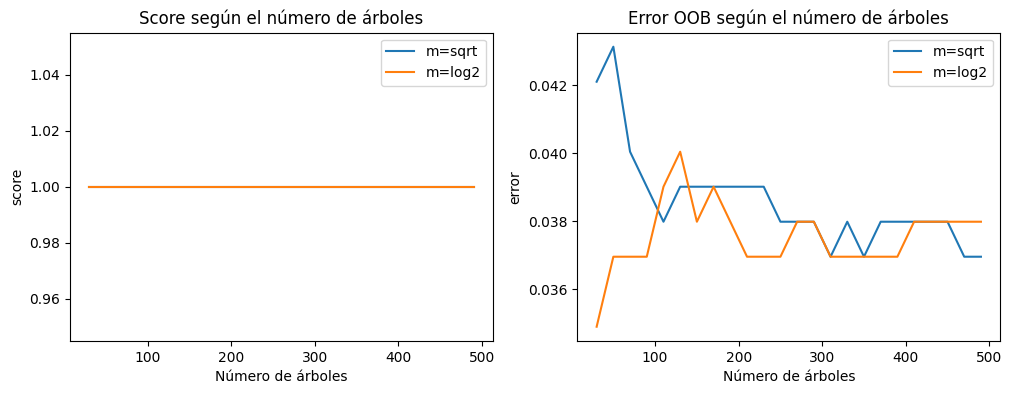

In [251]:
num_arboles = np.arange(30, 500, 20)
class_rf = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)
scores, errors = obtener_mejor_configuracion(class_rf, X_train, y_train, num_arboles)

In [ ]:
# Obtener el número de árboles que obtuvo el mejor score y el menor error OOB
print('Con {} árboles se obtuvo el mayor score'.format((np.argmax(scores[1]) + 3) * 20))
print('Con {} árboles se obtuvo el menor error OOB'.format((np.argmin(errors[1]) + 3) * 20))

In [ ]:
# Entrenamos el modelo
class_rf.set_params(n_estimators=60, max_features='log2')
class_rf.fit(X_train, y_train)

#prededimos los nuevos valores
Y_pred6 = class_rf.predict(X_test)
y_val_pred6=class_rf.predict(X_val)

Accuracy: 0.9655172413793104
Recall: 0.7777777777777778
Matriz de confusión:


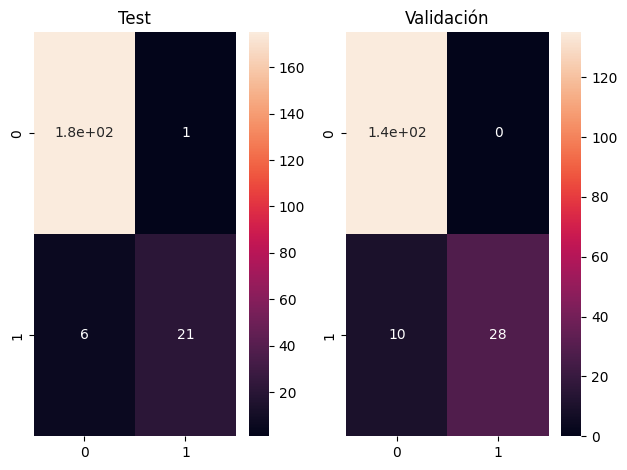

In [254]:
# Evaluamos la prediccion utilizando las metricas
acc6=accuracy_score(Y_test, Y_pred6)
recall6=recall_score(Y_test, Y_pred6)
conf_mat6=confusion_matrix(Y_test,Y_pred6)

val_acc6 = accuracy_score(y_val,  y_val_pred6)
val_recall6=recall_score(y_val, y_val_pred6)
val_conf_mat6=confusion_matrix(y_val,y_val_pred6)

acc_test.append(acc6)
recall_test.append(recall6)
conf_mat_test.append(conf_mat6)

acc_val.append(val_acc6)
conf_mat_val.append(val_conf_mat6)
recall_val.append(val_recall6)

print("Accuracy: {}".format(acc6))
print("Recall: {}".format(recall6))
print("Matriz de confusión:")

fig, axs = plt.subplots(1, 2)

sns.heatmap(conf_mat6, annot=True, ax=axs[0])
axs[0].set_title('Test')

sns.heatmap(val_conf_mat6, annot=True, ax=axs[1])
axs[1].set_title('Validación')

plt.tight_layout()
plt.show()

##COMPARATIVA DE TÉCNICAS

* **Técnica1** - Ajuste de parámetros del modelo
* **Técnica2** - *Subsampling* de la clase mayoritaria
* **Técnica3**- *Oversampling* de la clase minoritaria (duplicados)
* **Técnica4** - *Oversamplig* de la clase minoritaria (muestras sintéticas)
* **Técnica5** - Combinación *oversampling* + *subsampling*
* **Técnica6** - Método de ensamblaje

Para la evaluación de las técnicas tenemos que tener claro lo siguiente:

* **Alta precision y alto recall**: el modelo maneja perfectamente esa clase
* **Alta precision y bajo recall**: el modelo no detecta la clase muy bien, pero cuando lo hace es altamente confiable.
* **Baja precisión y alto recall**: La clase detecta bien la clase pero también incluye muestras de otras clases.
* **Baja precisión y bajo recall**: El modelo no logra clasificar la clase correctamente.

Cuando tenemos un dataset con desequilibrio, suele ocurrir que obtenemos un alto valor de precisión en la clase Mayoritaria y un bajo recall en la clase Minoritaria

El **F1 Score** de una clase es dada por la media harmonía de precisión y recall (2 x precision x recall / (precision+recall)). Es decir, combina precisión y recall en una sola métrica.

In [256]:
metricas_df=pd.DataFrame()
metricas_df['Técnica']=['Técnica1', 'Técnica2', 'Técnica3', 'Técnica4', 'Técnica5', 'Técnica6']
metricas_df['Test_acc']=acc_test
metricas_df['Test_recall']=recall_test
metricas_df['Val_acc']=acc_val
metricas_df['Val_recall']=recall_val

In [257]:
metricas_df

,Técnica,Test_acc,Test_recall,Val_acc,Val_recall
0,Técnica1,0.926108,0.851852,0.907514,0.763158
1,Técnica2,0.814286,0.903226,0.796610,0.733333
2,Técnica3,0.970238,0.944444,0.982517,0.971831
3,Técnica4,0.955357,0.969136,0.947552,0.942446
4,Técnica5,0.957198,0.967480,0.954128,0.981308
5,Técnica6,0.965517,0.777778,0.942197,0.736842


Como se puede observar las técnicas que mejor métricas han obtenido han sido la 3, la 4 y la 5. Vamos a calcular el F1-Score para elejir la mejor. 

In [259]:
metricas_df['F1_score_Test']=(2*metricas_df['Test_acc']*metricas_df['Test_recall'])/(metricas_df['Test_acc']+metricas_df['Test_recall'])
metricas_df['F1_score_Val']=(2*metricas_df['Val_acc']*metricas_df['Val_recall'])/(metricas_df['Val_acc']+metricas_df['Val_recall'])
metricas_df

,Técnica,Test_acc,Test_recall,Val_acc,Val_recall,F1_score_Test,F1_score_Val
0,Técnica1,0.926108,0.851852,0.907514,0.763158,0.887429,0.829100
1,Técnica2,0.814286,0.903226,0.796610,0.733333,0.856453,0.763663
2,Técnica3,0.970238,0.944444,0.982517,0.971831,0.957168,0.977145
3,Técnica4,0.955357,0.969136,0.947552,0.942446,0.962197,0.944992
4,Técnica5,0.957198,0.967480,0.954128,0.981308,0.962312,0.967528
5,Técnica6,0.965517,0.777778,0.942197,0.736842,0.861538,0.826961


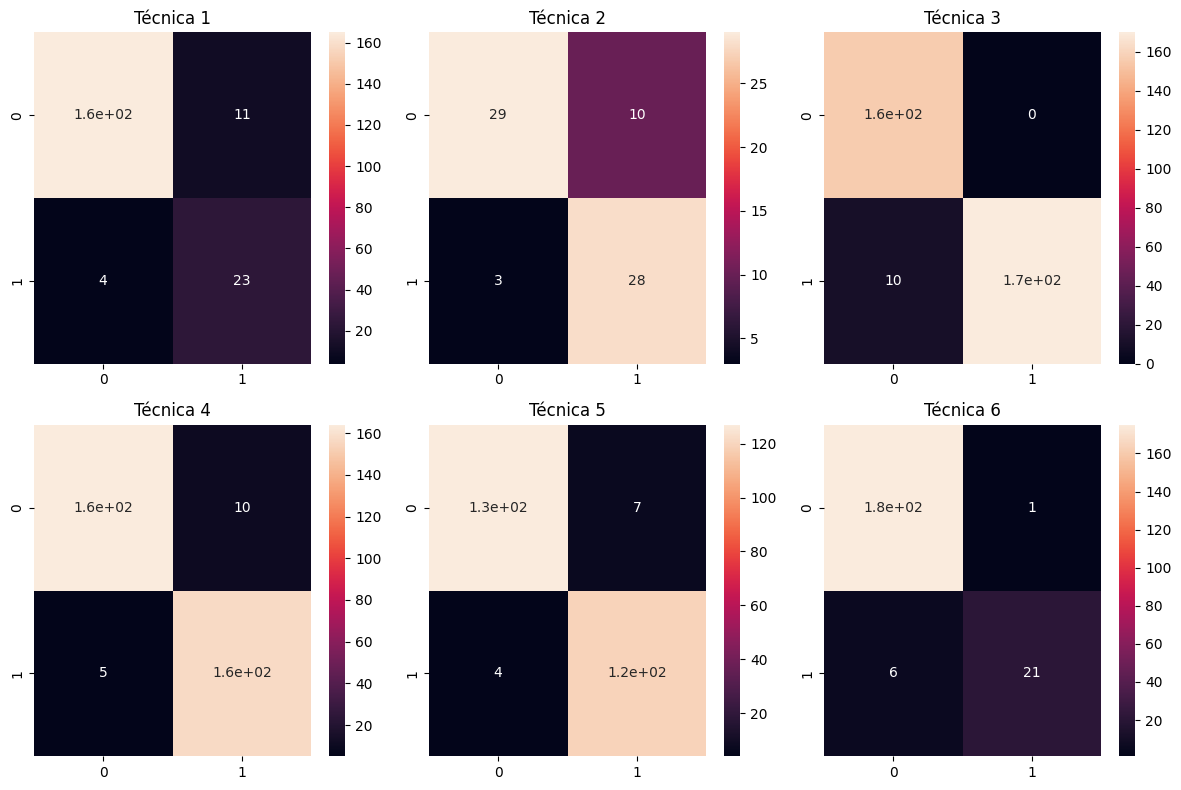

In [258]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i in range(6):
    row = i // 3  # Calculamos la fila del subplot
    col = i % 3   # Calculamos la columna del subplot
    sns.heatmap(conf_mat_test[i], annot=True, ax=axs[row, col])
    axs[row, col].set_title('Técnica {}'.format(i+1))

plt.tight_layout()
plt.show()

La técnica elegida para el desbalanceo de datos es la 5: Combinación de Oversampling + Subsampling